**Objective**

Sentiment analysis is a common use case of NLP where the idea is to classify the tweet as positive, negative or neutral depending upon the text in the tweet. This problem goes a way ahead and expects us to also determine the words in the tweet which decide the polarity of the tweet.

1. [Import packages](#1)
1. [Load data](#2)
1. [Data Exploration](#3)
    - Analysis of the Sentiment Column
    - Distribution of the Sentiment Column
    - What do we currently Know About our Data
1. [Generating Meta-Features](#4)
    - Jaccard Similarity Scores between text and Selected_text
    - Number of words in selected text and main text
    - Length of words in text and selected
    - Difference In Number Of words of Selected_text and Text
1. [Exploration on the meta-features](#5)
1. [Conclusion Of EDA](#6)
1. [Text Data Preprocessing](#7)
1. [Most common words](#8)
    - Most Common words in our Target-Selected Text
    - Most Common words in Text
    - Most common word for each sentiments
    - Unique word for each sentiments
1. [It's Time For WordClouds](#10)
    - Dimensionality Reduction with t-SNE (Doc2Vec)
    - Dimensionality Reduction with PCA (Doc2Vec)
1. [Ngram exploration](#11)
    - Distribution of bigram
    - Distribution of trigram
1. [Extracting the part of the tweet that reflects the sentiment : Resources](#12)
    - Question-Answering
    - Method with Pytorch and BERT

<a id="1"></a> <br>
## Import packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#!pip install chart_studio
#!pip install textstat

import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
import textstat
import random



# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot



# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer



from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from tqdm import tqdm

import os

import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch


import warnings
warnings.filterwarnings("ignore")

<a id="2"></a> <br>
## Load Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (27486, 4)
Testing data shape:  (3535, 3)


So We have 27486 tweets in the train set and 3535 tweets in the test set

In [4]:
print("There are {} percentage of test data proportion compared to train data".format(round(test.shape[0]/train.shape[0]*100,2)))

There are 12.86 percentage of test data proportion compared to train data


<a id="3"></a> <br>
## Data Exploration

In [25]:
# First few rows of the training dataset
train.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [26]:
# First few rows of the testing dataset
test.head()

,textID,text,sentiment
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive
1,fd1db57dc0,i'm done.haha. HOUSE MD marathon ulet,positive
2,2524332d66,I'm concerned for that family,positive
3,0fb19285b2,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have...,positive
4,e6c9e5e3ab,26th February,neutral


The columns denote the following:

- The textID of a tweet
- The text of a tweet
- The selected text which determines the polarity of the tweet
- sentiment of the tweet

The test dataset doesn't have the selected text column which needs to be identified.

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27486 entries, 0 to 27485
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27486 non-null  object
 1   text           27485 non-null  object
 2   selected_text  27485 non-null  object
 3   sentiment      27486 non-null  object
dtypes: object(4)
memory usage: 859.1+ KB


In [5]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Just one NULL value in text and selected_text/

In [6]:
train.dropna(inplace = True)

In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3535 entries, 0 to 3534
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3535 non-null   object
 1   text       3535 non-null   object
 2   sentiment  3535 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [7]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

**Analysis of the Sentiment Column**

Now, let's analyse and see how the Sentiment column looks like. I have only used the training dataset but the process will remain the same if we wish to to do it for the test dataset as well.

In [38]:
print('Positive tweet example :', train[train['sentiment'] == 'positive']['text'].values[1])
print()
print('Neutral tweet example :', train[train['sentiment'] == 'neutral']['text'].values[1])
print()
print('Negative tweet example :', train[train['sentiment'] == 'negative']['text'].values[1])

Positive tweet example :  haha better drunken tweeting you mean?

Neutral tweet example : says good (or should i say bad?) afternoon!  http://plurk.com/p/wxpdj

Negative tweet example : headache  wanna see my Julie


**Distribution of the Sentiment Column**

In [41]:
train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7786
Name: sentiment, dtype: int64

It'll be better if we could get a relative percentage instead of the count. It is very simple with value_counts and can be achieved with a minor modification in the above code. 

In [42]:
train['sentiment'].value_counts(normalize = True)

neutral     0.404475
positive    0.312243
negative    0.283282
Name: sentiment, dtype: float64

This is a better representation. About 40 percent of the tweets are neutral followed by positive and negative tweets.

It would be interesting to see if the distribution is also same in the test set.

In [43]:
test['sentiment'].value_counts(normalize = True)

neutral     0.404526
positive    0.312306
negative    0.283168
Name: sentiment, dtype: float64

**What do we currently Know About our Data:**

Before starting let's look at some things that we already know about the data and will help us in gaining more new insights:

- We Know that selected_text is a subset of text
- We know that selected_text contains only one segment of text,i.e,It does not jump between two sentences.For Eg:- If text is 'Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun. I had other plans for my morning' The selected text can be 'my boss was not happy w/ them. Lots of fun' or 'Lots of fun' but cannot be 'Morning,vendor and my boss,
- Thanks to this discussion:https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/138520 We know that neutral tweets have a jaccard similarity of 97 percent between text and selected_text

<a id="4"></a> <br>
##  Generating Meta-Features

I saw some notebook used them for their models :
 - Number of words in selected text and main text 
 - Length of words in text and selected 
 - Difference In Number Of words of Selected_text and Text
 - Jaccard Similarity Scores between text and Selected_text

**Jaccard Similarity Scores between text and Selected_text**

In [45]:
def jaccard(str1,str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)/ (len(a) + len(b) - len(c)))

In [55]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [56]:
jaccard = pd.DataFrame(results_jaccard, columns = ["text", "selected_text", "jaccard_score"])

In [57]:
jaccard.head()

,text,selected_text,jaccard_score
0,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,0.416667
1,Oh! Good idea about putting them on ice cream,Good,0.111111
2,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,0.888889
3,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0.875000
4,haha better drunken tweeting you mean?,better,0.166667


In [58]:
train = train.merge(jaccard, how = 'outer')
train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,0.416667
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,0.111111
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,0.888889
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,0.875000
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,0.166667


**Number of words in selected text and main text**

In [11]:
train['Num_Word_ST'] = train['selected_text'].apply(lambda x: len(str(x).split()))

**Length of words in text and selected** 

In [12]:
train['Num_Word_Text'] = train['text'].apply(lambda x: len(str(x).split()))

**Difference In Number Of words of Selected_text and Text**

In [13]:
train['diff_in_word'] = train['Num_Word_Text'] - train['Num_Word_ST']

Let's see the result :

In [63]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_Word_ST,Num_Word_Text,diff_in_word
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,0.416667,10,28,18
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,0.111111,1,9,8
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,0.888889,8,9,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,0.875000,7,9,2
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,0.166667,1,6,5


<a id="5"></a> <br>
## Exploration on the meta-features

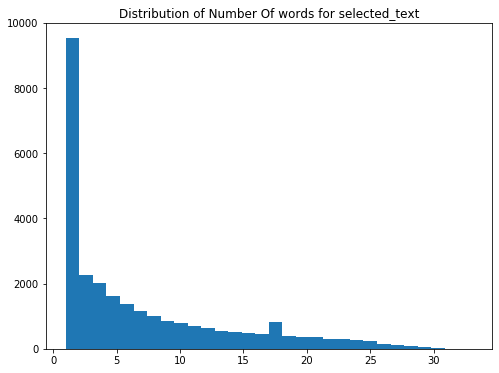

In [82]:
plt.figure(figsize = (8,6))
plt.hist(train['Num_Word_ST'], bins = 30)
plt.title('Distribution of Number Of words for selected_text');

The number of words plot is really interesting ,the tweets having number of words greater than 25 are very less and thus the number of words distribution plot is right skewed

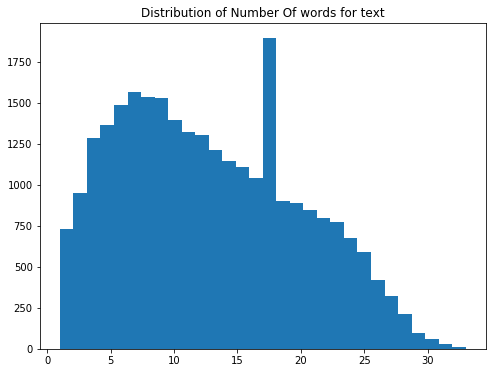

In [83]:
plt.figure(figsize = (8,6))
plt.hist(train['Num_Word_Text'], bins = 30)
plt.title('Distribution of Number Of words for text');

That's kind of right skewed too !

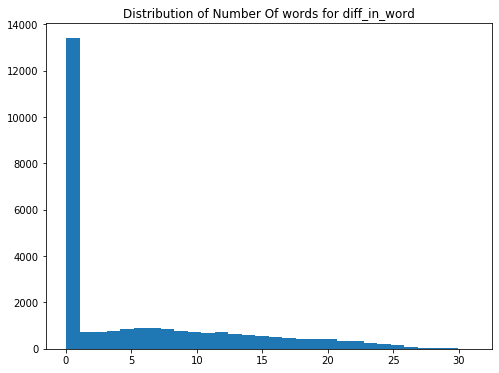

In [84]:
plt.figure(figsize = (8,6))
plt.hist(train['diff_in_word'], bins = 30)
plt.title('Distribution of Number Of words for diff_in_word');

Obviously most of the case are between 0 and 3, because selected text is an abstrac of text so..

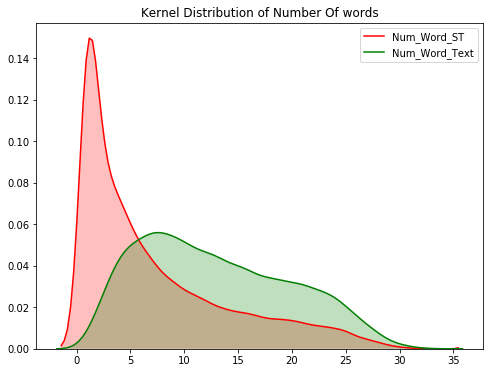

In [93]:
plt.figure(figsize = (8,6))
p = sns.kdeplot(train['Num_Word_ST'], shade = True, color = "r")
p = sns.kdeplot(train['Num_Word_Text'], shade = True, color = 'g')
plt.title('Kernel Distribution of Number Of words');

I think it will be more useful to see this for diff_in_word :

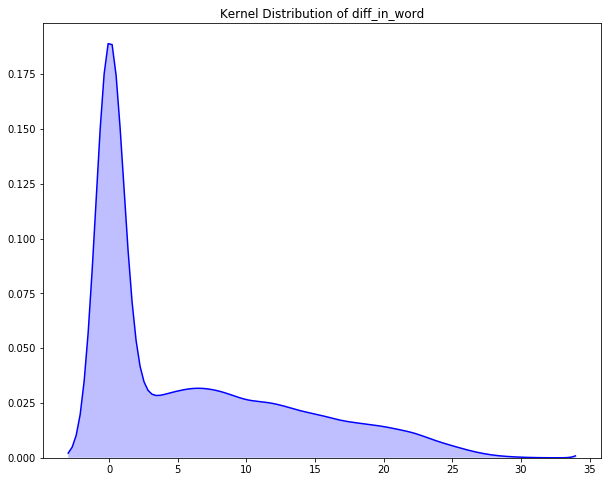

In [97]:
plt.figure(figsize = (10,8))
sns.kdeplot(train['diff_in_word'], shade = True, color = 'b', legend = False)
plt.title('Kernel Distribution of diff_in_word');

Let's see diff_in_word but by sentiment :

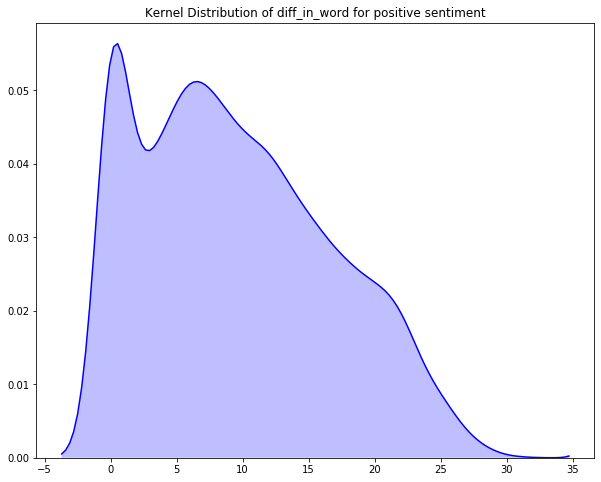

In [110]:
plt.figure(figsize = (10,8))
sns.kdeplot(train[train['sentiment'] == 'positive']['diff_in_word'], shade = True, color = 'b', legend = False )
plt.title('Kernel Distribution of diff_in_word for positive sentiment');

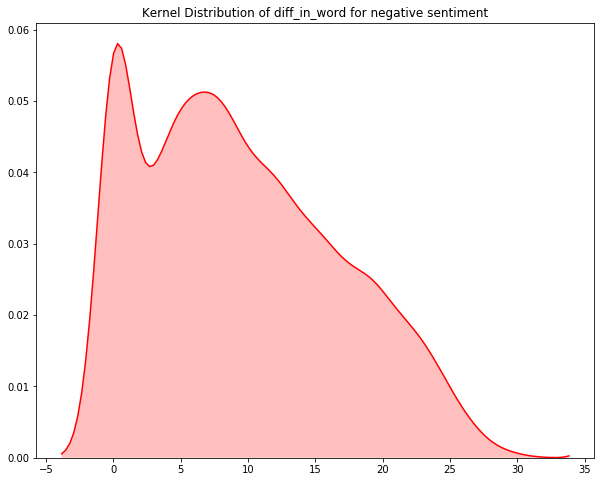

In [109]:
plt.figure(figsize = (10,8))
sns.kdeplot(train[train['sentiment'] == 'negative']['diff_in_word'], shade = True, color = 'r', legend = False )
plt.title('Kernel Distribution of diff_in_word for negative sentiment');

They looklike the same. I was not able to plot kde plot for neutral tweets because most of the values for difference in number of words were zero. 
Thus I will plot a distribution plot

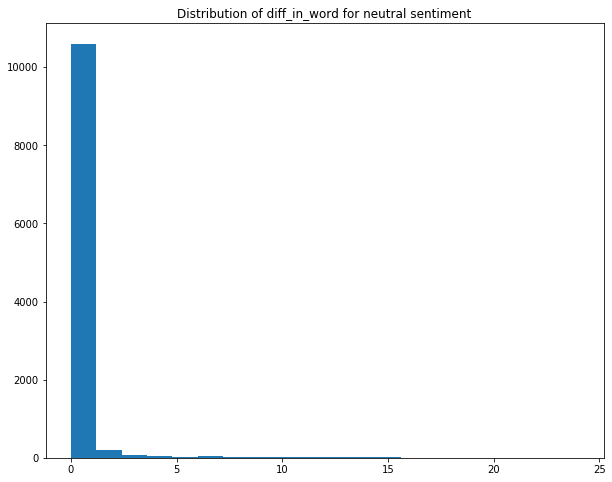

In [108]:
plt.figure(figsize = (10,8))
plt.hist(train[train['sentiment'] == 'neutral']['diff_in_word'], bins = 20)
plt.title('Distribution of diff_in_word for neutral sentiment');

Let's see the distribution of the jaccard score accros each sentiment :

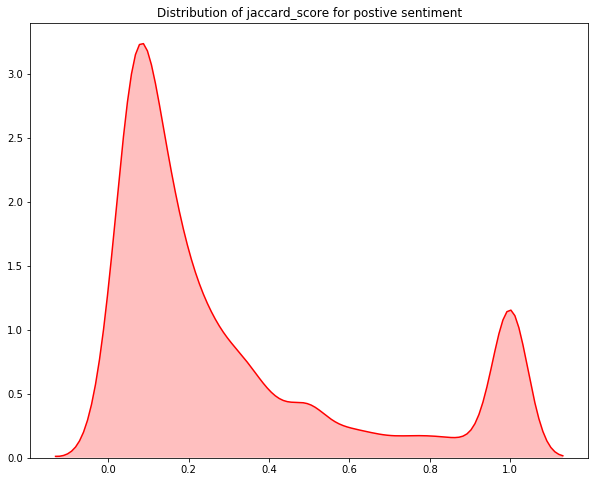

In [113]:
plt.figure(figsize = (10,8))
sns.kdeplot(train[train['sentiment'] == 'positive']['jaccard_score'], shade = True, color = 'r', legend = False).set_title('Distribution of jaccard_score for positive sentiment');

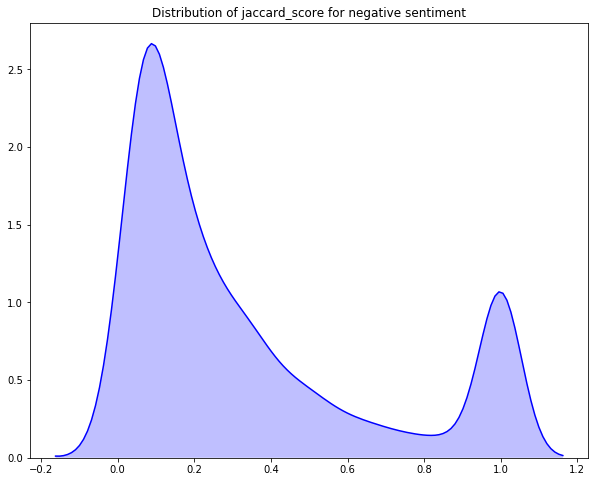

In [114]:
plt.figure(figsize = (10,8))
sns.kdeplot(train[train['sentiment'] == 'negative']['jaccard_score'], shade = True, color = 'b', legend = False).set_title('Distribution of jaccard_score for negative sentiment');

I was not able to plot kde of jaccard_scores of neutral tweets for the same reason,thus I will plot a distribution plot

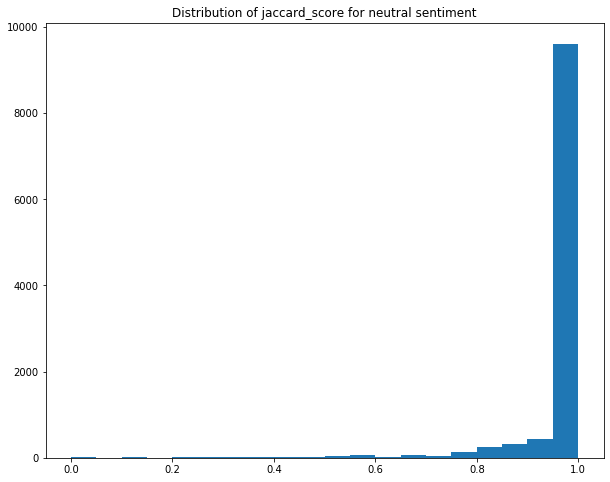

In [115]:
plt.figure(figsize = (10,8))
plt.hist(train[train['sentiment'] == 'neutral']['jaccard_score'], bins = 20)
plt.title('Distribution of jaccard_score for neutral sentiment');

We can see some interesting trends here:

- Positive and negative tweets have high kurtosis (right skewed) and thus values are concentrated in two regions narrow and high density
- Neutral tweets have a low kurtosis value and their is bump in density near values of 1

For those who don't know :

Kurtosis is the measure of how peaked a distribution is and how much spread it is around that peak
Skewness measures how much a curve deviates from a normal distribution

<a id="6"></a> <br>
## Conclusion Of EDA

We can see from the jaccard score plot that there is peak for negative and positive plot around score of 0,1 and 1 .That means there is a cluster of tweets where :
- there is a high similarity between text and selected texts
- there is a weak similarity between text and selected texti

If we can find those clusters then we can predict text for selected texts for those tweets irrespective of segment
Let's see if we can find those clusters,one interesting idea would be to check tweets which have number of words less than 3 in text, because there the text might be completely used as text

In [116]:
j = train[train['Num_Word_Text'] < 3]

In [123]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_Word_ST,Num_Word_Text,diff_in_word
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,0.416667,10,28,18
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,0.111111,1,9,8
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,0.888889,8,9,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,0.875000,7,9,2
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,0.166667,1,6,5


In [121]:
j.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.78858
neutral     0.97619
positive    0.76570
Name: jaccard_score, dtype: float64

The Jaccard score are high, so we can see that there is similarity between text (<= 2) and selected text so our intuition seems right. Let's have a closer look :

In [136]:
j[['text', 'selected_text']].head(15)

,text,selected_text
22,uh oh,uh oh
31,hello thereeeeeee,hello thereeeeeee
55,It's Raining!,It's Raining!
108,upgraded,upgraded
135,bbq party,bbq party
205,nope,nope
222,that's great!,great!
230,i agree,i agree
237,food...food...FOOD!,food...food...FOOD!
247,Awwwwwww holly,Awwwwwww holly


It's seemes clear that most of the times , text is used as selected text.
We can improve this by preprocessing the text which have word length less than 3. We will remember this information and use it in our model building.

It's time to clean our corpus 

<a id="7"></a> <br>
## Text Data Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Let's create a function which will perform the following tasks on the text columns:

- Make text lowercase,
- removes hyperlinks,
- remove punctuation
- removes numbers
- tokenizes
- removes stopwords

In [21]:
stop_words = stopwords.words("english")
stop_words.extend(['im', 'u'])
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text

In [22]:
train['text_clean'] = train['text'].apply(lambda x: clean_text(x))
train['selected_text_clean'] = train['selected_text'].apply(lambda x : clean_text(x))

Let's see the result :

In [24]:
train[['text', 'text_clean']].head()

,text,text_clean
0,Spent the entire morning in a meeting w/ a ven...,spent entire morning meeting vendor boss happy...
1,Oh! Good idea about putting them on ice cream,oh good idea putting ice cream
2,says good (or should i say bad?) afternoon! h...,says good say bad afternoon
3,i dont think you can vote anymore! i tried,dont think vote anymore tried
4,haha better drunken tweeting you mean?,haha better drunken tweeting mean


In [23]:
train[['selected_text', 'selected_text_clean']].head()

,selected_text,selected_text_clean
0,my boss was not happy w/ them. Lots of fun.,boss happy lots fun
1,Good,good
2,says good (or should i say bad?) afternoon!,says good say bad afternoon
3,i dont think you can vote anymore!,dont think vote anymore
4,better,better


<a id="8"></a> <br>
## Most common words

**Most Common words in our Target-Selected Text**

In [232]:
train['list'] = train['selected_text_clean'].apply(lambda x: str(x).split())

top = Counter([item for sublist in train['list'] for item in sublist])

mostcommon = pd.DataFrame(top.most_common(20))
mostcommon.columns = ['Common Word', 'Count']
mostcommon.head(20)

,Common Word,Count
0,good,1237
1,day,1041
2,love,890
3,happy,843
4,like,772
5,get,770
6,dont,762
7,go,696
8,cant,611
9,work,604


**Most Common words in Text**

In [272]:
train['list'] = train['text_clean'].apply(lambda x: str(x).split())


def top(corpus, n = None):
    top = Counter([item for sublist in corpus['list'] for item in sublist])
    mostcommon = pd.DataFrame(top.most_common(20))
    mostcommon.columns = ['Common Word', 'Count']
    return mostcommon.head(20)

top(train)

,Common Word,Count
0,day,2039
1,good,1544
2,get,1425
3,like,1344
4,go,1265
5,dont,1198
6,love,1119
7,work,1109
8,going,1096
9,today,1092


So we can see the Most common words in Selected text and Text are almost the same,which was obvious

**Most common word for each sentiments**

It would be a good idea to see the most common word for each sentiments :

In [234]:
positive = train[train['sentiment'] == 'positive']
negative = train[train['sentiment'] == 'negative']
neutral = train[train['sentiment'] == 'neutral']

In [276]:
print('The most common word in positive tweets')
top(positive)

The most common word in positive tweets


,Common Word,Count
0,day,1221
1,good,1042
2,love,873
3,happy,838
4,mothers,627
5,thanks,553
6,great,478
7,like,411
8,hope,396
9,get,367


In [277]:
print('The most common word in negative tweets')
top(negative)

The most common word in negative tweets


,Common Word,Count
0,like,476
1,dont,470
2,cant,464
3,get,436
4,miss,423
5,go,401
6,sad,389
7,work,386
8,sorry,339
9,really,339


In [278]:
print('The most common word in neutral tweets')
top(neutral)

The most common word in neutral tweets


,Common Word,Count
0,get,622
1,go,575
2,day,502
3,dont,489
4,going,479
5,work,476
6,like,457
7,got,453
8,lol,453
9,today,433


- Positive produces words like good,happy,thanks which is quite expected
- Negative produces words like miss,sad,sorry,bad which indicates negative emotions
- Neutral produces words like get,going,work which is sort of common words
- We could see "day" comes in all three sentiments.(These tweets might be indicating a event day.Hopefully we may come to know after competition)

In [239]:
raw_text = [word for word_list in train['list'] for word in word_list]

**Unique word for each sentiments**

In [240]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [241]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,greetings,7
4,presents,7
5,shared,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [242]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,devastated,6
7,noes,6
8,sob,6
9,dealing,6


In [243]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,hiya,6
3,mite,6
4,lighter,5
5,lecture,5
6,matthew,5
7,reader,5
8,bucks,5
9,sorta,5


By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets

<a id="10"></a> <br>
## It's Time For WordClouds

We will be building wordclouds in the following order:

- WordCloud of Neutral Tweets
- WordCloud of Positive Tweets
- WordCloud of Negative Tweets

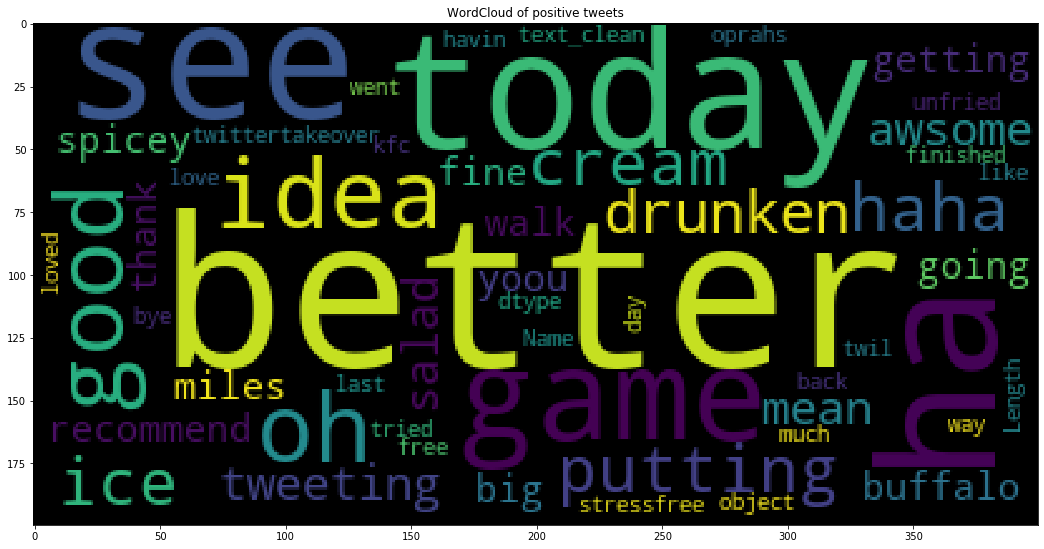

In [252]:
wc = WordCloud(stopwords = stop_words)
plt.figure(figsize = (18,12))
wc.generate(str(positive['text_clean']))
plt.imshow(wc)
plt.title('WordCloud of positive tweets');

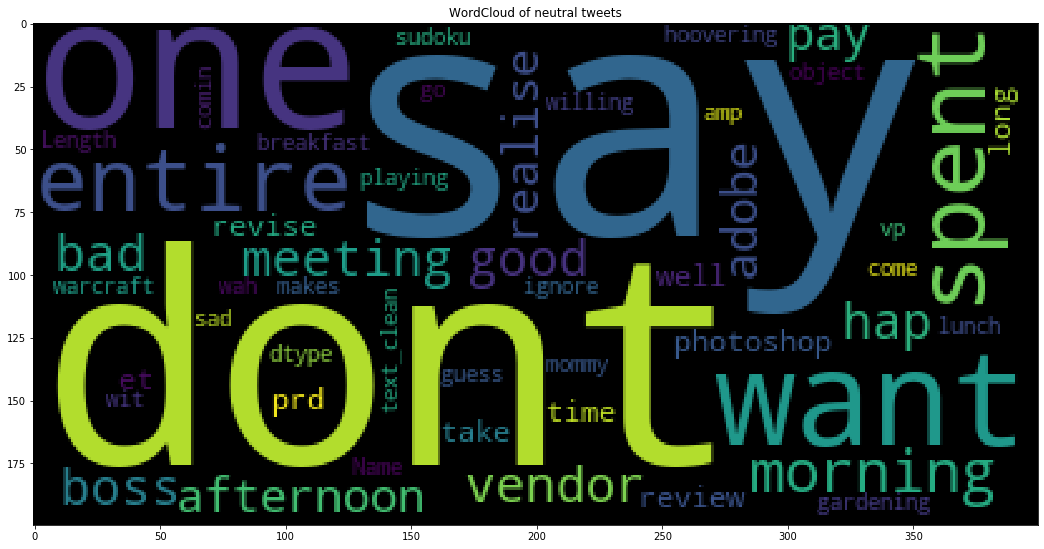

In [251]:
wc = WordCloud(stopwords = stop_words)
plt.figure(figsize = (18,12))
wc.generate(str(neutral['text_clean']))
plt.imshow(wc)
plt.title('WordCloud of neutral tweets');

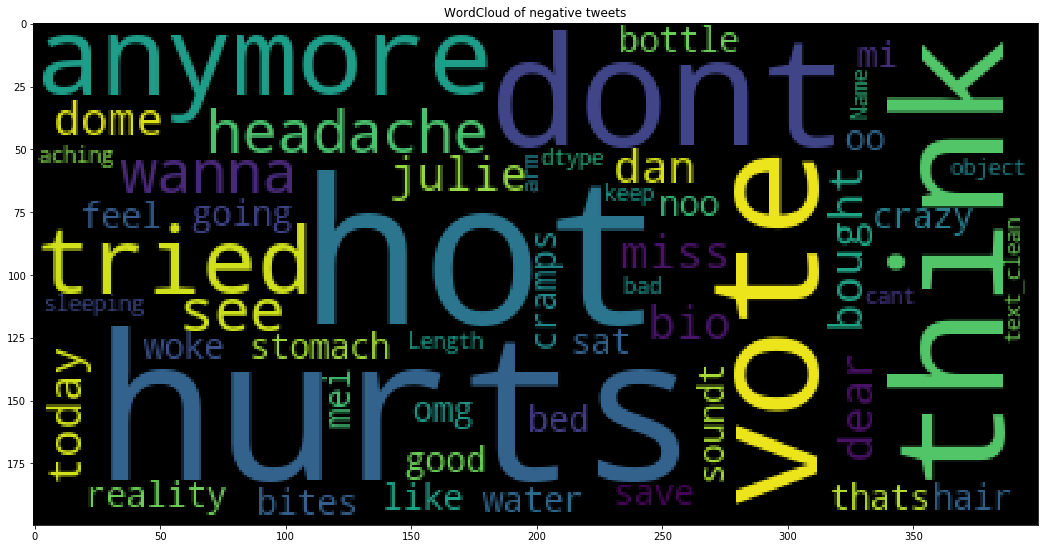

In [253]:
wc = WordCloud(stopwords = stop_words)
plt.figure(figsize = (18,12))
wc.generate(str(negative['text_clean']))
plt.imshow(wc)
plt.title('WordCloud of negative tweets');

<a id="11"></a> <br>
## Ngram exploration
To analyse more in depth the text column we will be extracting the N-Gram features.

N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. Here is a nice way to understand this:

![](https://i.stack.imgur.com/8ARA1.png)

Source: https://stackoverflow.com/questions/18193253/what-exactly-is-an-n-gram

We have already see the unigram above so let's go straight to bigram.

**Distribution of bigram**

In [279]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [370]:
positive_bigram = get_top_n_gram(positive['text_clean'], (2,2), 20)
negative_bigram = get_top_n_gram(negative['text_clean'], (2,2), 20)
neutral_bigram = get_top_n_gram(neutral['text_clean'], (2,2), 20)

In [368]:
def process(corpus):
    corpus = pd.DataFrame(corpus, columns= ['Text', 'count']).sort_values('count', ascending = True)
    return corpus

In [371]:
positive_bigram = process(positive_bigram)
negative_bigram = process(negative_bigram)
neutral_bigram = process(neutral_bigram)

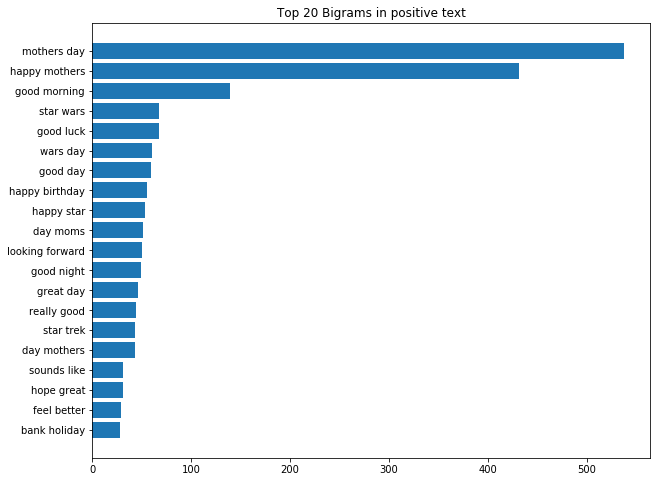

In [375]:
plt.figure(figsize = (10,8))
plt.barh(positive_bigram['Text'], positive_bigram['count'])
plt.title('Top 20 Bigrams in positive text');

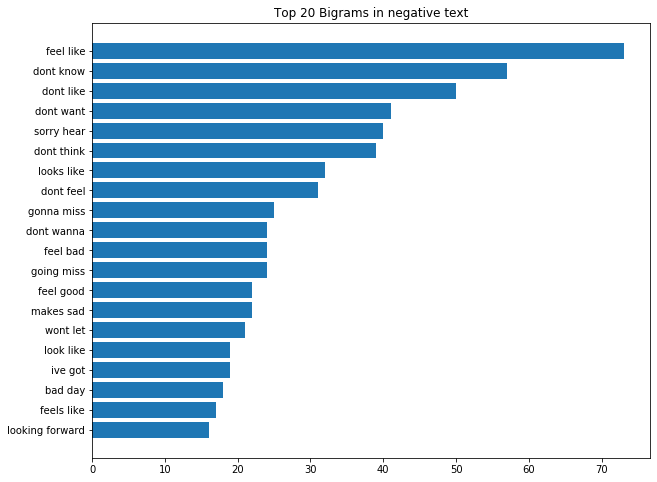

In [376]:
plt.figure(figsize = (10,8))
plt.barh(negative_bigram['Text'], negative_bigram['count'])
plt.title('Top 20 Bigrams in negative text');

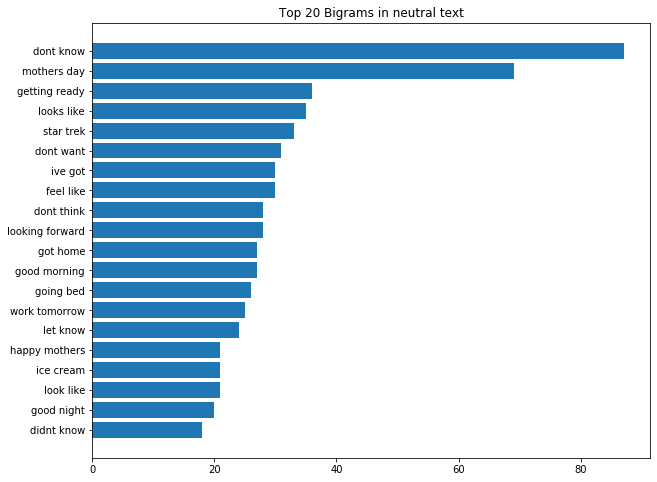

In [377]:
plt.figure(figsize = (10,8))
plt.barh(neutral_bigram['Text'], neutral_bigram['count'])
plt.title('Top 20 Bigrams in neutral text');

**distribution of trigram**

In [378]:
positive_trigram = get_top_n_gram(positive['text_clean'], (3,3), 20)
negative_trigram = get_top_n_gram(negative['text_clean'], (3,3), 20)
neutral_trigram = get_top_n_gram(neutral['text_clean'], (3,3), 20)

In [379]:
positive_trigram = process(positive_trigram)
negative_trigram = process(negative_trigram)
neutral_trigram = process(neutral_trigram)

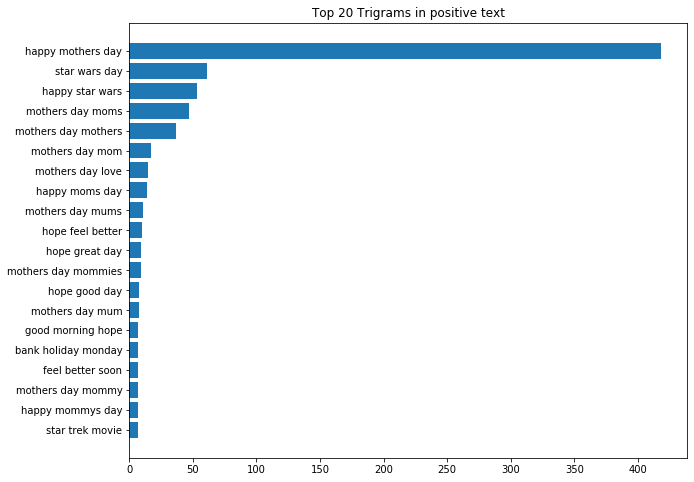

In [380]:
plt.figure(figsize = (10,8))
plt.barh(positive_trigram['Text'], positive_trigram['count'])
plt.title('Top 20 Trigrams in positive text');

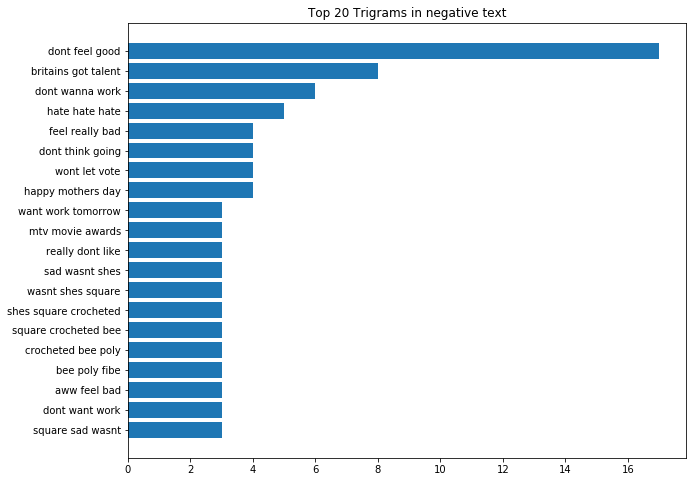

In [381]:
plt.figure(figsize = (10,8))
plt.barh(negative_trigram['Text'], negative_trigram['count'])
plt.title('Top 20 Trigrams in negative text');

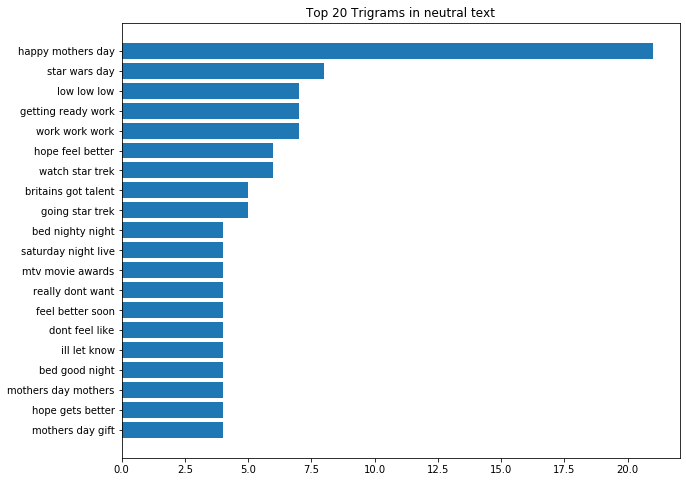

In [382]:
plt.figure(figsize = (10,8))
plt.barh(neutral_trigram['Text'], neutral_trigram['count'])
plt.title('Top 20 Trigrams in neutral text');

- "Day" was always a part among all sentiment tweets and thus confirmed the event.Well,"Happy Mothers day".All these tweets were collected around May 2nd Week.
- Positive bigrams and trigrams words are more biased towards mothers day.
- Negative ngrams are displaying negative emotional words.
- Neutral shows common words.Nothing much inference from this sentiment.

<a id="12"></a> <br>
## Extracting the part of the tweet that reflects the sentiment : Resources

There are a number of ways in which the problem can be approached and a lot of good solutions have been provided as notebooks which I would like to point out :

### A) Question-Answering 

Here's some solution with in mind the extractive question answering problem :

- Here is a solution by [Cheongwoong Kang](https://www.kaggle.com/cheongwoongkang) provided in his notebook titled: [**DistilBERT-QA Starter (+ cross-validation)**](https://www.kaggle.com/cheongwoongkang/distilbert-qa-starter-cross-validation)

- Here is another solution by  [Jonathan Besomi](https://www.kaggle.com/jonathanbesomi) provided in his notebook titled: [**Question-Answering Starter pack**](https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack/output)



### B) Method with Pytorch and BERT

[This](https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch) is kernel by *Abhishek Thakur* which his based on his  videos on youtube. If you want to understand more, be sure to check them out.

In [383]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/XaQ0CBlQ4cY" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>